In [1]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
f = open(os.devnull, 'w')
sys.stdout = f

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def parse_filename(filename):
    fn_re = "pool-(?P<pool>.+)_expr-(?P<expr>.+)_sw-(?P<sw>\d+)"
    fn_re = fn_re + "_es-(?P<es>\d+)_qd-(?P<qd>\d+)_pg-(?P<pg>\d+)"
    fn_re = fn_re + "_rt-(?P<rt>\d+)_if-(?P<if>.+)_cv.*\.log"
    fn_re = re.compile(fn_re)
    match = fn_re.match(os.path.basename(filename))
    assert match
    return match

In [3]:
def short_ename(ename):
    mapping = {
        'bytestream_n1_write': 'n1wr',
        'bytestream_n1_append': 'n1ap',
        'bytestream_11': '11wr',
        'map_n1': 'n1kv',
        'map_11': '11kv'
    }
    return mapping[ename]

def short_iface(iface):
    mapping = {
        'cls_full': 'XATTR',
        'cls_full_hdr_idx': 'data',
        'vanilla': 'librados',
        'cls_check_epoch': 'xattr (no index)',
        'cls_no_index_wronly': 'data (raw)',
        'cls_check_epoch_hdr': 'data (epoch)'
    }
    return mapping[iface]

In [4]:
def read_trace(filename, trimFrontSec=30, trimBackSec=30):
    ### read up raw throughput file
    trace = pd.read_table(filename, sep=" ",
        header=None, names=("completed", "throughput"))
    
    ### shift timeseries to have zero start time
    trace.completed = pd.to_datetime(trace.completed, unit="ns")
    trace.completed = trace.completed - min(trace.completed)
    trace.completed = trace.completed / pd.Timedelta(seconds=1)
    
    ### trim front and back of trace
    trace = trace[(trace.completed > trimFrontSec) & (trace.completed <
        max(trace.completed) - trimBackSec)]
    trace.completed = trace.completed - min(trace.completed)
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='completed', ascending=True, inplace=True)
    return trace

In [5]:
def plot_throughput_trace(trace, md, ax):
    trace.throughput = pd.rolling_mean(trace.throughput, window=5, min_periods=1)
    ename = short_ename(md.group('expr'))
    iface = short_iface(md.group('if'))
    label = iface
    ax.plot(trace.completed, trace.throughput, label=label)
    ax.set_title('Storing Metadata in XATTR vs. Data')
    ax.set_ylabel('Appends per Second')
    ax.set_xlabel('Time (Sec)')

In [6]:
def plot_traces(traces, fn, finish=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for filename in traces:
        trace_data = read_trace(filename)
        md = parse_filename(filename)
        print os.path.basename(filename), 'mean', trace_data.throughput.mean()
        plot_throughput_trace(trace_data, md, ax)
    if finish:
        lgd = ax.legend(loc='center left', bbox_to_anchor=(0.82, 0.0))
        plt.savefig(fn + '.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))
    else:
        return ax

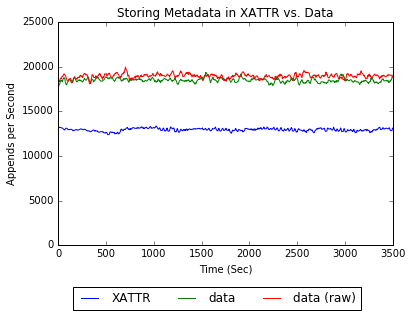

In [10]:
# Ingest the input
traces_all_ops = "zlog-popper/experiments/basic-cls-overhead/results.pd.basic_cls_overhead.node0.04-22-2016_00-48-56/*_es-1024_*cls_full*.log"
trace_raw_data = "zlog-popper/experiments/basic-cls-overhead/results.pd.basic_cls_overhead.node0.04-22-2016_00-48-56/*_es-1024_*cls_no_index_wronly*.log"
traces = glob.glob(traces_all_ops) + glob.glob(trace_raw_data)

# Plot it
ax = plot_traces(traces, 'cls_xattr-vs-data.png', finish=False)
ax.set_ylim(0, 25000)
ax.set_xlim(0, 3500)
ax.legend(loc='best', ncol=3, bbox_to_anchor=(0.84,0.0), bbox_transform=plt.gcf().transFigure)
plt.savefig('cls_xattr-vs-data.png', dpi=300, bbox_inches='tight')